In [1]:
%matplotlib inline

import os
import numpy as np
import pickle
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import heapq
import torch
import cv2

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from torchvision import transforms

In [2]:
os.getcwd()

'/home/pim/Documents/MGI2/Thesis/Thesis-Scripts'

In [3]:
concept_score = pd.read_csv('../data/concept_scores.csv', index_col = 0)

In [4]:
son_votes = pd.read_csv('../data/son_votes.csv', index_col = 0)

In [2]:
SON_VECTOR_PATH = '../data/son_tensors.pickle'

## Cluster Scenic-Or-Not images

Load all tensors of the Scenic-Or-Not dataset as a dictionary. The dictionary contains the following structure: <br>
img_index : [image_name, image_path, image_tensor]

In [3]:
with open(SON_VECTOR_PATH, 'rb') as handle:
    son_acts = pickle.load(handle)

In [7]:
len(son_acts.keys())

212102

Compute the matrix of activations from all SoN images.

In [14]:
if os.path.exists('../data/son_matrix.npy'):
    son_matrix = np.load('../data/son_matrix.npy')

else:
    cuda = torch.device('cuda')
    son_matrix = torch.zeros(len(son_acts.keys()), son_acts[list(son_acts.keys())[0]][2].shape[0]).cuda

    for i in tqdm(range(len(son_acts.keys()))):
        img_tensor = son_acts[list(son_acts.keys())[i]][2].unsqueeze(0).cuda()
        son_matrix[i] = img_tensor

    son_matrix = np.asarray(son_matrix.to(device='cpu'))
    np.save('../data/son_matrix.npy', son_matrix)

This image is not in the dataset and thus the index should be not be in the dictionary. For confirmation:

In [9]:
'52642' in son_acts.keys()

False

Apply a minibatch k-means clustering to cluster all images into 50 groups. A mini-batch clustering is applied as the sample size is about 212100 which requires high computational time. Several amount of clusters have been tried, at around 50 no 'structure' can be seen in the clusters. The clusters are visualized with t-SNE. 

In [4]:
if not os.path.exists('../data/son_matrix_normalized.npy'):
    son_matrix_norm = normalize(son_matrix)
    np.save('../data/son_matrix_normalized.npy', son_matrix_norm)
else:
    son_matrix_norm = np.load('../data/son_matrix_normalized.npy')

In [11]:
np.random.seed(42)
num_clusters = 50
kmeans = MiniBatchKMeans(n_clusters = num_clusters, batch_size = 100, init = 'k-means++', max_iter = 2000)

kmeans.fit(son_matrix_norm)


In [5]:
if not os.path.exists('../data/son_clusters_50_2048.npy'):
    clusters = kmeans.cluster_centers_
    np.save('../data/son_clusters_50_2048.npy', clusters)
else: 
    clusters = np.load('../data/son_clusters_50_2048.npy')

In [13]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(clusters)

Each cluster is visualized in a 2D space using t-SNE. Each cluster is also annotated to make it easier to check which clusters are neighbouring. Which is useful when looking at the concepts representing the clusters

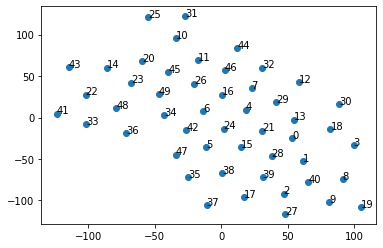

In [14]:
cluster_labels = list(range(50))

plt.scatter(X_2d[:,0], X_2d[:,1])
for i, txt in enumerate(cluster_labels):
    plt.annotate(str(txt), (X_2d[:,0][i], X_2d[:,1][i]))


For each cluster the average concepts scores are calculated. The concepts which show an average concept score larger than 0 should represent the cluster. 

In [6]:
# every image is assigned to a cluster, the assignment is stored as a label
if not os.path.exists('../data/image_cluster_labels.npy'):
    labels = kmeans.labels_
    np.save('../data/image_cluster_labels.npy', labels)
    
else:
    labels = np.load('../data/image_cluster_labels.npy')

In [7]:
labels.shape

(212102,)

In [17]:
cluster_dict = {}
for i in tqdm(range(num_clusters)):
    concept_score_cluster = concept_score.loc[(labels == i),:]
    mean_score = concept_score_cluster.mean()
    scenicness_score = round(son_votes.loc[(labels==i),'Average'].mean(),2)
    cluster_dict['cluster_' + str(i)] = [mean_score[mean_score > 0].sort_values(ascending=False), scenicness_score]

In [18]:
for key in cluster_dict.keys():
    print(key, ": scenicness score: ", cluster_dict[key][1])
    print(cluster_dict[key][0])
    print('\n')

cluster_0 : scenicness score:  3.76
tree                   573.042931
bush                   456.771779
embankment             300.398421
fence                  209.552665
earth                  144.648371
field                  129.984944
bleachers-outdoor-s    117.324370
path                    31.186116
dtype: float64


cluster_1 : scenicness score:  2.46
building    564.502314
sky         361.960891
tree         83.975636
dtype: float64


cluster_2 : scenicness score:  3.34
building                 968.591678
tree                     819.164830
sky                      430.997549
sidewalk                 369.068132
roof                     247.067943
castle-s                  73.493412
observatory-outdoor-s     19.706165
dtype: float64


cluster_3 : scenicness score:  4.53
rock                969.364674
tree                798.813205
aqueduct-s          763.373387
bridge-s            692.920575
bridge              619.317984
bush                492.583721
water               180.17

cluster_19 : scenicness score:  4.25
roof                     1481.584546
mansion-s                1066.036748
farm-s                    988.851163
dacha-s                   966.133645
abbey-s                   961.390201
cabin-outdoor-s           922.946901
building                  877.792950
hovel                     819.731820
house                     788.472885
mission-s                 687.351460
military_hut-s            665.164504
tree                      644.691643
granary-s                 643.821960
earth                     610.084402
sky                       607.074387
garage-outdoor-s          513.485211
windmill-s                510.301830
hut-s                     482.272377
cloud                     397.528432
cottage-s                 395.826276
guardhouse-s              390.122712
barn-s                    375.412853
observatory-outdoor-s     354.342522
cloister-outdoor-s        348.369198
attic-s                   212.255616
castle-s                  208.829592
e

dtype: float64


cluster_34 : scenicness score:  4.6
tree                  1163.083357
earth                  851.402929
bush                   783.481970
field                  676.969200
embankment             430.406931
drainage_ditch-s       414.842149
marsh-s                377.472224
grass                  243.082231
japanese_garden-s      217.710329
mountain               200.621288
ski_slope-s            187.960047
water                  173.486799
sky                    141.851173
forest_path-s          130.080575
yard-s                 118.595644
botanical_garden-s     116.893783
forest                  81.688673
irrigation_ditch-s      25.456339
dirt_track-s            21.658825
dtype: float64


cluster_35 : scenicness score:  3.06
tree                984.582625
road                844.341446
building            774.671625
access_road-s       660.313861
street-s            564.692683
roundabout-s        542.523487
sky                 448.084651
car                 433.231958

The concepts related to each cluster show what kind of images can be found in these clusters. There is still overlap between several clusters especially in relation to concepts like 'tree', 'earth', 'field', 'bush'. These are concepts which can be present in almost every image. However, several interesting clusters are also determined:
- cluster 9: related to buildings
- cluster 12: related to pasture
- cluster 14: related to areas with mountains, hills and long views
- cluster 17: related to city environment
- cluster 22: related to coastal areas
- cluster 36: related to snow
- cluster 37: related to transportation
- cluster 41: related to water

Define a cluster of interest:

In [130]:
cluster_num = 37

In [42]:
img_in_cluster = list(labels == cluster_num) # get boolean array of image is specified cluster
img_cluster_idx = [t for t, value in enumerate(img_in_cluster) if value] #get the index value of every image in the cluster
img_cluster_idx = [t+1 if t >= 201047 else t+1 if t>= 52642 else t for t in img_cluster_idx]

Extract the paths to the images and randomly sample a specified number of images

In [20]:
## On laptop
paths = []
for img_idx in img_cluster_idx:
    img_name = son_acts[str(img_idx)][1].split('/')[-1]
    paths.append('../son_images/images/' + img_name)

# # On Guanabana server
# paths = []
# for img_idx in tqdm(img_cluster_idx):
#     paths.append(son_acts[str(img_idx)][1])

cluster_random_sample = random.sample(paths, 9)

Plot the images

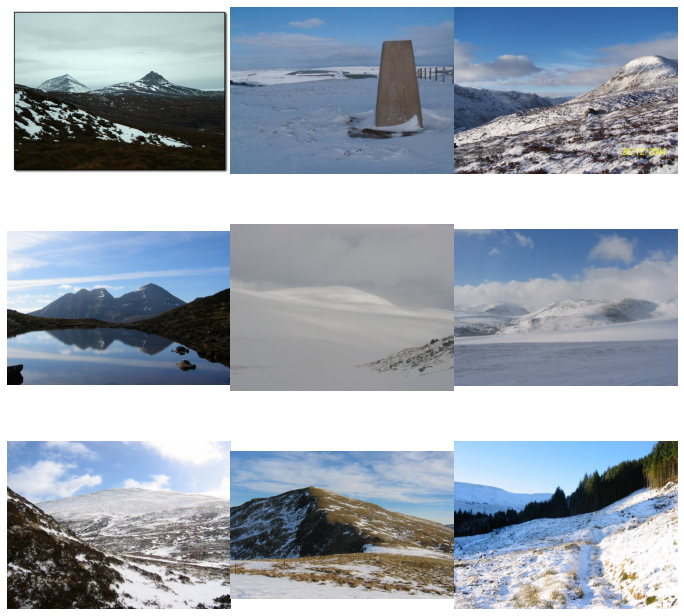

In [11]:
fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(3, 3, i+1) for i in range(len(cluster_random_sample))]

for idx, a in enumerate(ax):
    img = plt.imread(paths[idx])
    a.axis('off')
    a.imshow(img)

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Every cluster has a cluster centroid described as a vector. The most similar images 9 to the cluster centroid of interest are displayed

In [131]:
# extract cluster centroid vector
cluster_centroid = clusters[cluster_num]
cluster_centroid = cluster_centroid.reshape(1,2048)

In [132]:
# extract image vectors assigned to the cluster
cluster_imgs = son_matrix_norm[labels == cluster_num, :]

In [133]:
cluster_imgs.shape

(1779, 2048)

In [134]:
# calculate the cosine similarity between the cluster centroid and the cluster images. Transpose the vector to a row vector
cluster_similar_imgs = cosine_similarity(cluster_centroid, son_matrix_norm).T

In [135]:
# extract the indices of the 9 most similar images
similar_idxs = heapq.nlargest(8, range(len(cluster_similar_imgs)), cluster_similar_imgs.take)
similar_idxs = [t+2 if t >= 201047 else t+1 if t>= 52642 else t for t in similar_idxs]

In [136]:
## On laptop
sim_paths = []
for sim_idx in similar_idxs:
    img_name = son_acts[str(sim_idx)][1].split('/')[-1]
    sim_paths.append('../son_images/images/' + img_name)


## On guanabana server
# sim_paths = []
# for sim_idx in similar_idxs:
#     sim_paths.append(son_acts[str(sim_idx)][1])

In [137]:
img_transform = transforms.Compose([transforms.CenterCrop(400)])

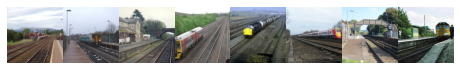

In [138]:
fig = plt.figure(figsize=(9,9))
ax = [fig.add_subplot(1, 9, i+1) for i in range(len(similar_idxs))]

for idx, a in enumerate(ax):
    img = Image.open(sim_paths[idx])
    crop_img = img_transform(img)
    crop_img = np.asarray(crop_img)
    a.axis('off')
    a.imshow(crop_img)

fig.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('../images/clusters/transportation.jpg', bbox_inches='tight')
plt.show()